In [ ]:
#| default_exp methods.visualization

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import networkx as nx

# Boxplot Summary

In [ ]:
#| export

def simulation_boxplot_summary(data, 
                               param1_values, 
                               param2_values, 
                               title, 
                               ylabel, 
                               parameter_names = ['Paramter 1', 'Parameter 2'],
                               legend_loc = 2,
                               legend_cols = 3,
                               legend_fontsize = 12
                              ):
    '''
    data: 3D array, with simulation results. First two dimensions give value of a simulation parameter, third dimension gives the simulation number.
    '''


    
    A = np.shape(data)[0] #param1
    B = np.shape(data)[1] #param2
    C = np.shape(data)[2] #simulations
    # Define colors for B indices
    colors = plt.cm.viridis(np.linspace(0, 1, B))  # B distinct colors
    
    d = 3 #priming softmax index
    for b in range(B):
        box_data = [data[a, b, :] for a in range(A)]
        positions = np.arange(A) + (b - B / 2) * 0.1  # Adjust positions to avoid overlap
        plt.boxplot(box_data, positions=positions, widths=0.1, patch_artist=True, 
                    boxprops=dict(facecolor=colors[b], alpha=0.6), 
                    medianprops=dict(color='black'))
        # Calculate and add 95% credible interval error bars
        for a in range(A):
            mean_val = np.mean(data[a, b, :])
            ci_low, ci_high = stats.t.interval(0.95, df=C-1, loc=mean_val, scale=stats.sem(data[a, b, :]))
            plt.errorbar(positions[a], mean_val, yerr=[[mean_val - ci_low], [ci_high - mean_val]], fmt='o', color='black')
    
    # Create legend
    legend_patches = [plt.Line2D([0], [0], color=colors[b], lw=4, label=f'{parameter_names[1]}={param2_values[b]}') for b in range(B)]
    plt.legend(handles=legend_patches, loc = legend_loc, ncol = legend_cols, fontsize = legend_fontsize)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(parameter_names[0])
    plt.xticks(range(A), labels=[f"{param1_values[a]}" for a in range(A)])

In [1]:
#| export

import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(matrix, 
                 title="Expectation of Memory Traces", 
                 xlabel="Trace", 
                 ylabel="Time Step", 
                 color="Blues", 
                 extent=None, 
                 figsize=(8, 6),
                 xticks=None,
                 xtick_labels=None,
                 yticks=None,
                 ytick_labels=None,
                 ax=None,
                 vmin=None,
                 vmax=None,
                 label_scale=1.0
                ):
    """
    Plots a heatmap of the given matrix using the intensity of a single color.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        show = True
    else:
        show = False  # Don't show if plotting to existing axis

    nrows, ncols = matrix.shape

    # Set extent so each pixel spans [i, i+1] in axis coords
    if extent is None:
        extent = [0, ncols, nrows, 0]  # left, right, bottom, top

    im = ax.imshow(matrix, cmap=plt.colormaps.get_cmap(color), 
                   aspect='auto', extent=extent, vmin=vmin, vmax=vmax)

    tick_fontsize = 10 * label_scale
    label_fontsize = 12 * label_scale
    title_fontsize = 14 * label_scale
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.invert_yaxis()

    # Default xticks at centers
    if xticks is None:
        xticks = np.arange(ncols)
        ax.set_xticks(xticks + 0.5)
        if xtick_labels is None:
            xtick_labels = [str(i+1) for i in xticks]
        ax.set_xticklabels(xtick_labels, fontsize=tick_fontsize)
    else:
        ax.set_xticks(xticks)
        if xtick_labels is not None:
            ax.set_xticklabels(xtick_labels, fontsize=tick_fontsize)

    # Default yticks at centers
    if yticks is None:
        yticks = np.arange(nrows)
        ax.set_yticks(yticks + 0.5)
        if ytick_labels is None:
            ytick_labels = [str(i+1) for i in yticks]
        ax.set_yticklabels(ytick_labels, fontsize=tick_fontsize)
    else:
        ax.set_yticks(yticks)
        if ytick_labels is not None:
            ax.set_yticklabels(ytick_labels, fontsize=tick_fontsize)

    plt.colorbar(im, ax=ax)

    if show:
        plt.tight_layout()
        plt.show()

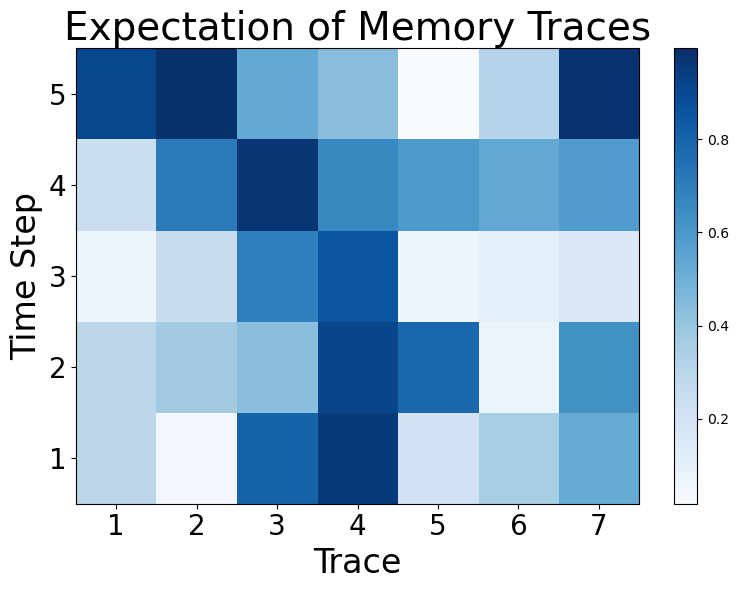

In [2]:
test_data = np.random.rand(5,7)
plot_heatmap(test_data)

In [ ]:
#| export

def visualize_time_step(t, observations, m_expectations, s_expectations, actions, surprise_data, H_matrices, glow_matrices, reinforcement_data):
    # Define number of panels and relative heights
    num_panels_col1 = 3
    num_panels_col2 = 2
    
    # Heights of individual panels (can be customized)
    heights_col1 = [4, 2, 2, 2]  # taller at top
    heights_col2 = [5, 5]   # shorter panels
    
    # Set up figure
    fig = plt.figure(figsize=(12, 10))  # overall figure size
    
    # Use GridSpec with total number of rows equal to sum of individual panel heights
    gs = gridspec.GridSpec(
        nrows=max(sum(heights_col1), sum(heights_col2)),
        ncols=2,
        width_ratios=[8, 4],  # wider first column
        figure=fig
    )
    axes_col1 = []

    num_m_nodes = np.shape(m_expectations)[1]
    # Place axes for first plot (encodings)
    actions = actions + 1 #set actions to correspond to stimulus number
    observations = np.append(observations, np.expand_dims(actions, axis = 1), axis = 1)
    encoded_obs = np.append(observations[:min(t+1,num_m_nodes),:], np.zeros((max(0, num_m_nodes -1 - t),np.shape(observations)[1])), axis = 0)
    if t >= num_m_nodes:
        encoded_obs[-1] = observations[t,:] #put current observation in final trace encoding
    ax = fig.add_subplot(gs[0:4, 0])
    plot_heatmap(encoded_obs.transpose(), ax = ax, 
                 xlabel = "Time Step", ylabel = "", 
                 title = "Encoded Observations", 
                 vmin = 0, 
                 vmax = np.max(observations),
                 yticks = [0.5,1.5,2.5],
                 ytick_labels = ["reward", "stimulus", "action"]
                )
    ax.set_yticks([0.99,1.99], minor=True)
    ax.set_xticks(range(num_m_nodes), minor = True)
    ax.yaxis.grid(which = "minor", color='black', linestyle='-', linewidth=0.5)
    ax.xaxis.grid(color='black', linestyle='--', linewidth=0.5)
    ax.xaxis.grid(which=  'minor', color='black', linestyle='--', linewidth=0.5)
    plt.vlines(x = min(t,num_m_nodes -1), ymin = 0, ymax = np.shape(observations)[1], color = "red")
    axes_col1.append(ax)

    # Place axes for third plot (expectation)
    ax = fig.add_subplot(gs[4:6, 0])
    advantages = np.log(np.mean(surprise_data[:min(t+1,num_m_nodes)])/surprise_data[1:min(t+1,num_m_nodes+1)]) #get advantages for nodes up to t (node t-1 gets the surprise at time t; we include node t in the data to vizualize, but not in the average used to compute advantage) 
    if t <= (num_m_nodes - 1):
        advantages = np.append(advantages, np.zeros(num_m_nodes - t)) #set valence of unencoded traces to zero
        advantages[num_m_nodes-1] = np.log(np.mean(surprise_data[:min(t+1,num_m_nodes)])/surprise_data[0]) #add advantage of last trace (encodes surprise at time step 0)
    else:
        advantages[num_m_nodes-1] = np.log(np.mean(surprise_data[:min(t+1,num_m_nodes)])/surprise_data[t]) #add advantage of last trace (encodes surprise at current time step))
    scale = np.max(np.absolute(advantages)) #used to center color scale at 0
    plot_heatmap(np.expand_dims(advantages, axis = 0), 
                 ax = ax, 
                 xlabel = "Trace Index", 
                 ylabel = "", 
                 title = 'Trace Advantage', 
                 yticks = [0,1],
                 color = 'PiYG',
                 vmin = -scale,
                 vmax = scale
                )
    axes_col1.append(ax)
    
    # Place axes for third plot (expectation)
    ax = fig.add_subplot(gs[6:8, 0])
    plot_heatmap(m_expectations[t:t+1,:], 
                 ax = ax, 
                 xlabel = "Trace Index", 
                 ylabel = "", 
                 title = f'Trace Expectations: Suprise = {np.round(surprise_data[t], decimals = 2)}, Advantage = {np.round(reinforcement_data[t], decimals = 2)}', 
                 vmin = 0, 
                 vmax = 1,
                 yticks = [0,1]
                )
    axes_col1.append(ax)
    
    plt.tight_layout()
    plt.show()

In [ ]:
#| export
def plot_circular_network(colors: list, highlight_index: int, ax = None, figwidth = 4) -> None:
    """
    Plot a circular network where each node is colored according to the `colors` list,
    and the node at `highlight_index` has a bright green border.
    """
    if ax is None:
        fig = plt.figure(figsize=(figwidth,figwidth))
        ax = fig.add_subplot(111)
    else:
        plt.sca(ax)  # Set current axis
    num_nodes = len(colors)
    if highlight_index >= num_nodes or highlight_index < 0:
        raise ValueError("highlight_index must be a valid index within the range of the colors list")

    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    # Optionally add edges to make it look like a circular network
    for i in range(num_nodes):
        G.add_edge(i, (i + 1) % num_nodes)

    #costum circular pos to get clockwise transitions
    angle_step = -2 * np.pi / num_nodes
    radius = 1
    pos = {
        i: ( radius * np.cos(np.pi/2 + i * angle_step), radius * np.sin(np.pi/2 + i * angle_step))
        for i in range(num_nodes)
    }

    # Draw nodes
    node_border_colors = ['lime' if i == highlight_index else 'black' for i in range(num_nodes)]
    linewidths = [3 if i == highlight_index else 0.2 for i in range(num_nodes)]
    nx.draw_networkx_nodes(
        G, pos,
        node_color=colors,
        edgecolors=node_border_colors,
        linewidths=linewidths,
        node_size=500 * figwidth  # Increased node size (display coordinates)
    )

    # Draw edges and labels (optional)
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    ax.set_xlim([-1.5, 1.5])
    ax.set_ylim([-1.5, 1.5])
    #plt.axis('equal')  # Maintain aspect ratio
    plt.axis('off')
    if ax is None:
        plt.show()

## Example

In [ ]:
plot_circular_network(colors = ["green", "lightgrey", "lightgrey", "blue", "lightgrey", "lightgrey"], highlight_index = 2, figwidth = 4)